In [8]:
# Manipulación y análisis de datos
import pandas as pd
import numpy as np

# Visualización de datos
import matplotlib.pyplot as plt
import seaborn as sns

# Expresiones regulares y procesamiento de strings
import re
import string

# ==== Librerías de NLP ====
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# ==== Librerías de Machine Learning ====
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.utils.class_weight import compute_class_weight
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Descargar recursos esenciales de NLTK (ejecutar una vez, comentar después de la primera ejecución)
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Configurar estética de gráficos para mejores visuales
plt.style.use('ggplot')
sns.set(style='whitegrid')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\osorn\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\osorn\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\osorn\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


**Cargando el conjunto de datos**

In [9]:
import pandas as pd

# Cargar conjunto de datos desde el repositorio de Hugging Face
splits = {'train': 'data/train-00000-of-00001.parquet', 'validation': 'data/validation-00000-of-00001.parquet', 'test': 'data/test-00000-of-00001.parquet'}
df_train = pd.read_parquet("hf://datasets/google-research-datasets/poem_sentiment/" + splits["train"])
df_validation = pd.read_parquet("hf://datasets/google-research-datasets/poem_sentiment/" + splits["validation"])
df_test = pd.read_parquet("hf://datasets/google-research-datasets/poem_sentiment/" + splits["test"])

In [10]:
# Explorar la estructura del conjunto de datos
print("=== RESUMEN DEL CONJUNTO DE DATOS ===")
print(f"Forma del conjunto de entrenamiento: {df_train.shape}")
print(f"Forma del conjunto de validación: {df_validation.shape}")
print(f"Forma del conjunto de prueba: {df_test.shape}")

print("\n=== COLUMNAS ===")
print("Columnas:", df_train.columns.tolist())

print("\n=== PRIMERAS FILAS DEL CONJUNTO DE ENTRENAMIENTO ===")
print(df_train.head())

print("\n=== TIPOS DE DATOS ===")
print(df_train.dtypes)

print("\n=== VALORES FALTANTES ===")
print(df_train.isnull().sum())

print("\n=== DISTRIBUCIÓN DE ETIQUETAS ===")
print(df_train['label'].value_counts())

=== RESUMEN DEL CONJUNTO DE DATOS ===
Forma del conjunto de entrenamiento: (892, 3)
Forma del conjunto de validación: (105, 3)
Forma del conjunto de prueba: (104, 3)

=== COLUMNAS ===
Columnas: ['id', 'verse_text', 'label']

=== PRIMERAS FILAS DEL CONJUNTO DE ENTRENAMIENTO ===
   id                                         verse_text  label
0   0  with pale blue berries. in these peaceful shad...      1
1   1                it flows so long as falls the rain,      2
2   2                 and that is why, the lonesome day,      0
3   3  when i peruse the conquered fame of heroes, an...      3
4   4            of inward strife for truth and liberty.      3

=== TIPOS DE DATOS ===
id             int32
verse_text    object
label          int64
dtype: object

=== VALORES FALTANTES ===
id            0
verse_text    0
label         0
dtype: int64

=== DISTRIBUCIÓN DE ETIQUETAS ===
label
2    555
0    155
1    133
3     49
Name: count, dtype: int64


=== TEXTOS DE MUESTRA POR ETIQUETA ===

--- ETIQUETA 0 (Cantidad: 155) ---
1. and that is why, the lonesome day,
2. and so on. then a worthless gaud or two,
3. sounded o'er earth and sea its blast of war,

--- ETIQUETA 1 (Cantidad: 133) ---
1. with pale blue berries. in these peaceful shades--
2. that has a charmingly bourbon air.
3. brightly expressive as the twins of leda,

--- ETIQUETA 2 (Cantidad: 555) ---
1. it flows so long as falls the rain,
2. and very venus of a pipe.
3. who the man, who, called a brother.

--- ETIQUETA 3 (Cantidad: 49) ---
1. when i peruse the conquered fame of heroes, and the victories of mighty generals, i do not envy the generals,
2. of inward strife for truth and liberty.
3. the red sword sealed their vows!

=== ESTADÍSTICAS DE LONGITUD DE TEXTO ===
count    892.000000
mean      38.337444
std       11.535211
min        7.000000
25%       31.000000
50%       38.000000
75%       44.000000
max      109.000000
Name: text_length, dtype: float64


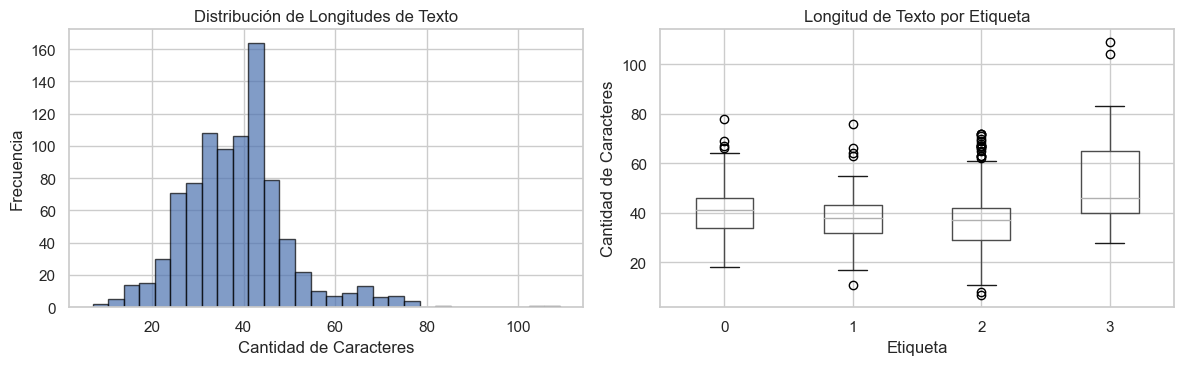

In [11]:
# Examinar textos de muestra para cada etiqueta para entender las categorías de sentimiento
print("=== TEXTOS DE MUESTRA POR ETIQUETA ===")
for label in sorted(df_train['label'].unique()):
    print(f"\n--- ETIQUETA {label} (Cantidad: {len(df_train[df_train['label'] == label])}) ---")
    samples = df_train[df_train['label'] == label]['verse_text'].head(3)
    for i, text in enumerate(samples, 1):
        print(f"{i}. {text}")

# También revisar la distribución de longitud de los textos
print("\n=== ESTADÍSTICAS DE LONGITUD DE TEXTO ===")
df_train['text_length'] = df_train['verse_text'].str.len()
print(df_train['text_length'].describe())

# Visualizar la distribución de longitud de texto
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(df_train['text_length'], bins=30, alpha=0.7, edgecolor='black')
plt.title('Distribución de Longitudes de Texto')
plt.xlabel('Cantidad de Caracteres')
plt.ylabel('Frecuencia')

plt.subplot(1, 2, 2)
df_train.boxplot(column='text_length', by='label', ax=plt.gca())
plt.title('Longitud de Texto por Etiqueta')
plt.xlabel('Etiqueta')
plt.ylabel('Cantidad de Caracteres')
plt.suptitle('')

plt.tight_layout()
plt.show()

## 📊 Interpretación de Estadísticas y Gráficas de Longitud de Texto

### 📈 **Estadísticas de Longitud de Texto:**
Las estadísticas descriptivas nos revelan características importantes del conjunto de datos:

- **Promedio (mean)**: ~38 caracteres por verso
- **Mediana (50%)**: 38 caracteres - muy similar al promedio, indicando una distribución relativamente simétrica
- **Rango**: De 7 a 109 caracteres - gran variabilidad en la longitud de los versos
- **Cuartiles**: 
  - Q1 (25%): 31 caracteres
  - Q3 (75%): 44 caracteres
  - Rango intercuartílico: 13 caracteres

### 📊 **Gráfica 1 - Distribución de Longitudes de Texto:**
Esta gráfica de histograma muestra que:

- **Distribución casi normal**: La mayoría de versos tienen entre 30-50 caracteres
- **Pico central**: Concentración máxima alrededor de los 35-40 caracteres
- **Cola derecha**: Algunos versos excepcionalmente largos (hasta 109 caracteres)
- **Textos cortos**: Pocos versos muy cortos (menos de 20 caracteres)

### 📈 **Gráfica 2 - Longitud de Texto por Etiqueta:**
El diagrama de caja (boxplot) revela patrones interesantes por categoría de sentimiento:

- **Etiqueta 0 (Melancólico/Negativo)**: Longitud típica, distribución compacta
- **Etiqueta 1 (Positivo/Placentero)**: Similar a la etiqueta 0, textos moderados
- **Etiqueta 2 (Neutral)**: La más común, longitud estándar con algunos valores atípicos
- **Etiqueta 3 (Intenso/Dramático)**: **Textos notablemente más largos** - esto tiene sentido porque los versos dramáticos tienden a ser más descriptivos y elaborados

### 🎯 **Implicaciones para el Análisis de Sentimientos:**
1. **Consistencia**: La mayoría de textos tienen longitud similar, facilitando el procesamiento
2. **Variabilidad por sentimiento**: Los textos dramáticos/intensos son más largos, lo que podría ser una característica distintiva
3. **Preprocesamiento**: Necesitaremos considerar esta variabilidad en la longitud al vectorizar los textos

=== ANÁLISIS DETALLADO DE LONGITUD POR ETIQUETA ===

--- ETIQUETA 0 (Melancólico/Negativo) ---
Promedio: 40.4 caracteres
Mediana: 41.0 caracteres
Desviación estándar: 10.1
Rango: 18 - 78 caracteres
Muestras: 155

--- ETIQUETA 1 (Positivo/Placentero) ---
Promedio: 38.0 caracteres
Mediana: 38.0 caracteres
Desviación estándar: 9.8
Rango: 11 - 76 caracteres
Muestras: 133

--- ETIQUETA 2 (Neutral) ---
Promedio: 36.6 caracteres
Mediana: 37.0 caracteres
Desviación estándar: 10.7
Rango: 7 - 72 caracteres
Muestras: 555

--- ETIQUETA 3 (Intenso/Dramático) ---
Promedio: 51.8 caracteres
Mediana: 46.0 caracteres
Desviación estándar: 18.1
Rango: 28 - 109 caracteres
Muestras: 49



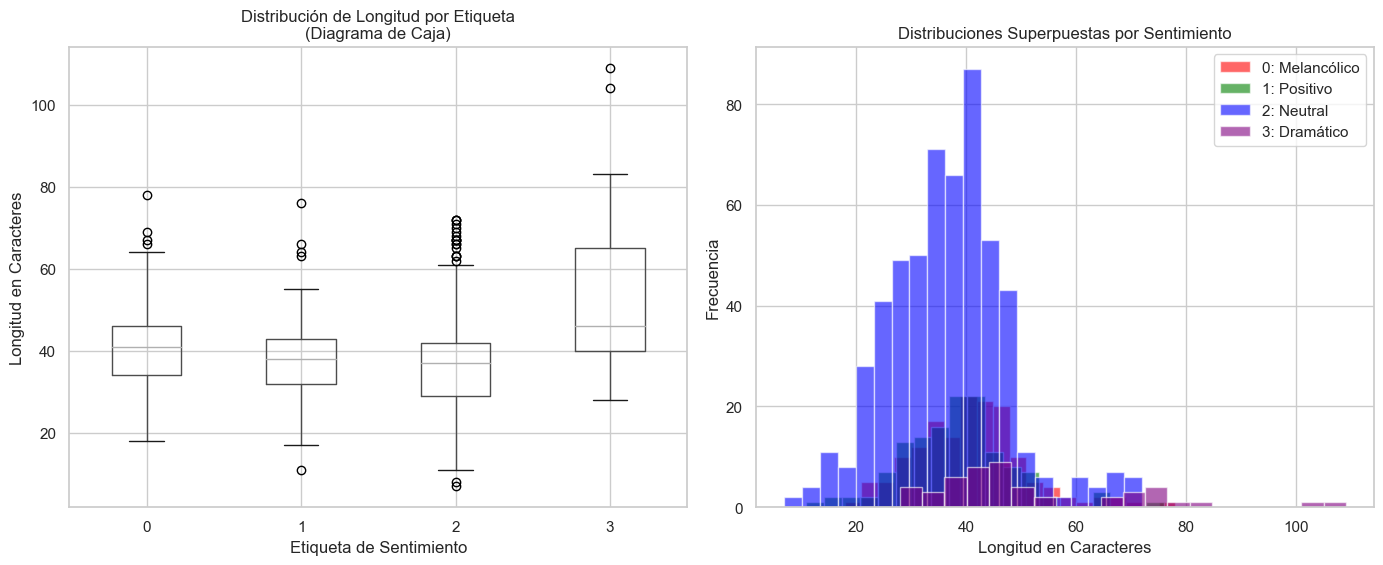

=== ANÁLISIS DE DESBALANCE DE CLASES ===
Etiqueta 0: 155 muestras (17.4%)
Etiqueta 1: 133 muestras (14.9%)
Etiqueta 2: 555 muestras (62.2%)
Etiqueta 3: 49 muestras (5.5%)

Ratio de desbalance (clase más común / clase menos común): 11.3:1


In [12]:
# Análisis estadístico más detallado por etiqueta
print("=== ANÁLISIS DETALLADO DE LONGITUD POR ETIQUETA ===\n")

for label in sorted(df_train['label'].unique()):
    subset = df_train[df_train['label'] == label]['text_length']
    
    # Mapeo de etiquetas a nombres descriptivos
    label_names = {
        0: "Melancólico/Negativo",
        1: "Positivo/Placentero", 
        2: "Neutral",
        3: "Intenso/Dramático"
    }
    
    print(f"--- ETIQUETA {label} ({label_names[label]}) ---")
    print(f"Promedio: {subset.mean():.1f} caracteres")
    print(f"Mediana: {subset.median():.1f} caracteres")
    print(f"Desviación estándar: {subset.std():.1f}")
    print(f"Rango: {subset.min()} - {subset.max()} caracteres")
    print(f"Muestras: {len(subset)}")
    print()

# Crear una visualización adicional para comparar distribuciones
plt.figure(figsize=(14, 6))

# Gráfico de violín para mostrar distribuciones completas
plt.subplot(1, 2, 1)
df_train.boxplot(column='text_length', by='label', ax=plt.gca())
plt.title('Distribución de Longitud por Etiqueta\n(Diagrama de Caja)')
plt.xlabel('Etiqueta de Sentimiento')
plt.ylabel('Longitud en Caracteres')
plt.suptitle('')

# Histograma superpuesto por etiquetas
plt.subplot(1, 2, 2)
colors = ['red', 'green', 'blue', 'purple']
labels = ['Melancólico', 'Positivo', 'Neutral', 'Dramático']

for i, (label, color, name) in enumerate(zip(sorted(df_train['label'].unique()), colors, labels)):
    subset = df_train[df_train['label'] == label]['text_length']
    plt.hist(subset, bins=20, alpha=0.6, color=color, label=f'{label}: {name}')

plt.title('Distribuciones Superpuestas por Sentimiento')
plt.xlabel('Longitud en Caracteres')
plt.ylabel('Frecuencia')
plt.legend()

plt.tight_layout()
plt.show()

# Estadísticas de desbalance de clases
print("=== ANÁLISIS DE DESBALANCE DE CLASES ===")
class_counts = df_train['label'].value_counts().sort_index()
total_samples = len(df_train)

for label in class_counts.index:
    percentage = (class_counts[label] / total_samples) * 100
    print(f"Etiqueta {label}: {class_counts[label]} muestras ({percentage:.1f}%)")

print(f"\nRatio de desbalance (clase más común / clase menos común): {class_counts.max() / class_counts.min():.1f}:1")

**Descripción de las columnas del conjunto de datos:**

- **id**: Índice del ejemplo
- **verse_text**: El texto del verso del poema
- **label**: La etiqueta de sentimiento

**Mapeo de etiquetas:**
- 0 = negativo
- 1 = positivo
- 2 = sin impacto (neutral)
- 3 = mixto (tanto negativo como positivo)

**Nota**: El conjunto de datos original usa diferentes índices de etiquetas (negativo = -1, sin impacto = 0, positivo = 1)

In [ ]:
# Mostrar información básica
print("Forma de los datos de entrenamiento:", df_train.shape)
print("Forma de los datos de prueba:", df_test.shape)
print("Forma de los datos de validación:", df_validation.shape)

# Vista previa de las primeras filas de los datos de entrenamiento
print("\nPrimeras 10 filas de los datos de entrenamiento:")
display(df_train.head(10))

Training data shape: (892, 4)
Test data shape: (104, 3)
Validation data shape: (105, 3)

First 5 rows of training data:


,id,verse_text,label,text_length
0,0,with pale blue berries. in these peaceful shad...,1,50
1,1,"it flows so long as falls the rain,",2,35
2,2,"and that is why, the lonesome day,",0,34
3,3,"when i peruse the conquered fame of heroes, an...",3,109
4,4,of inward strife for truth and liberty.,3,39
5,5,the red sword sealed their vows!,3,32
6,6,and very venus of a pipe.,2,25
7,7,"who the man, who, called a brother.",2,35
8,8,"and so on. then a worthless gaud or two,",0,40
9,9,to hide the orb of truth--and every throne,2,42


In [ ]:
# Verificar valores faltantes
print("\nValores faltantes en datos de entrenamiento:")
print(df_train.isnull().sum())


print("\nValores faltantes en datos de validación:")
print(df_validation.isnull().sum())

print("\nValores faltantes en datos de prueba:")
print(df_test.isnull().sum())


Missing values in training data:
id             0
verse_text     0
label          0
text_length    0
dtype: int64

Missing values in validation data:
id            0
verse_text    0
label         0
dtype: int64

Missing values in test data:
id            0
verse_text    0
label         0
dtype: int64


In [ ]:
#Sentiment distribution in training data

sentimientos={
    0: 'negative',
    1: 'positive',
    2: 'no impact',
    3: 'mixed'
}

df_train['sentiment']=df_train['label'].map(sentimientos)
df_test['sentiment']=df_test['label'].map(sentimientos)
df_validation['sentiment']=df_validation['label'].map(sentimientos)
df_train['sentiment'].value_counts()


sentiment
no impact    555
negative     155
positive     133
mixed         49
Name: count, dtype: int64

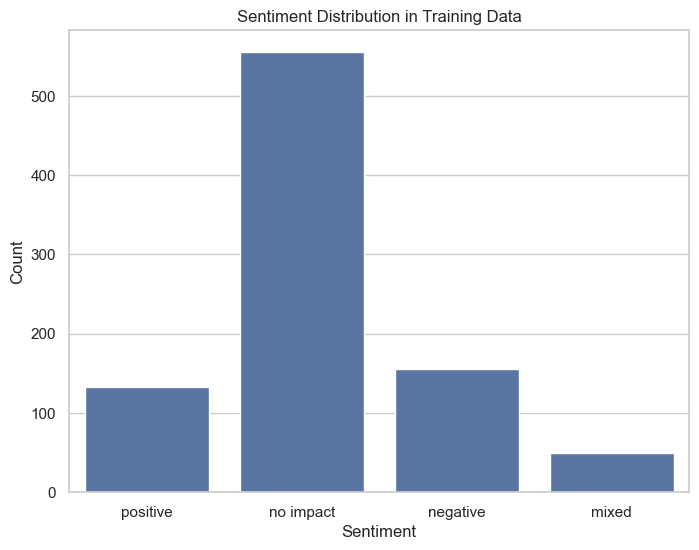

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
#Visualize sentiment distribution

plt.figure(figsize=(8, 6))
sns.countplot(data=df_train, x='sentiment')
plt.title('Sentiment Distribution in Training Data')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

In [19]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\osorn\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.


True

In [21]:
# Clean and preprocess text before modeling to remove noise and standardize the input.
# This pipeline covers: lowercasing, removing URLs, HTML, mentions, hashtags, punctuation, numbers, and extra whitespace.
# Tokenization, stopword removal, and lemmatization are also included for robust NLP.

def clean_text(text):
    """
    Clean and preprocess text data.

    Args:
        text (str): Input text

    Returns:
        str: Cleaned text
    """
    if pd.isna(text):
        return ""

    # Convert to lowercase
    text = text.lower()

    # Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)

    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)

    # Remove user mentions
    text = re.sub(r'@\w+', '', text)

    # Remove hashtags (keeping the text after #)
    text = re.sub(r'#(\w+)', r'\1', text)

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

def preprocess_text(text):
    """
    Full preprocessing pipeline: clean, tokenize, remove stopwords, and lemmatize.

    Args:
        text (str): Input text

    Returns:
        str: Preprocessed text
    """
    if pd.isna(text):
        return ""

    # Clean text
    text = clean_text(text)

    # Tokenize
    tokens = word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Lemmatize
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Join tokens back into text
    processed_text = ' '.join(tokens)

    return processed_text

In [22]:
stop_words = set(stopwords.words('english'))
print(stop_words)

{'we', 'itself', 'do', 'here', 'been', "i've", "doesn't", 'll', "that'll", 'our', 'they', 'those', 'about', 'below', 'during', 'their', 'i', "mustn't", 'a', 'same', 'for', 'then', 'off', 's', 'o', 'me', "he's", 'theirs', 'y', 'so', "they're", 'yourself', "you've", 'of', 'once', 'above', 'when', "i'll", 'ma', "isn't", 'if', 'have', "she's", "they've", 'through', "shan't", "you'll", 'in', 'where', 'both', 'his', 'or', 'it', "she'd", "hasn't", 'not', "i'm", 'which', 'over', 'isn', 'her', 'under', 'while', 'because', "couldn't", 'but', 'each', 'from', 'weren', 'your', 'until', 'd', 'at', 'be', "it'd", 'ourselves', 'yourselves', 'my', 'out', "we've", 'will', "we're", 'she', 'other', 'now', "wasn't", 'this', 'needn', "she'll", 'doesn', 'shouldn', 'yours', 'why', 'had', 'them', 'its', "didn't", 'is', 'haven', "shouldn't", 't', 'that', 'can', 'shan', 'few', 'having', 'didn', 'further', 'again', 'some', 'to', 'was', "weren't", "won't", 'am', 'how', "they'd", 'after', 'all', 'on', 'couldn', 'nor

In [23]:
df_train['processed_text'] = df_train['verse_text'].apply(preprocess_text)
df_validation['processed_text'] = df_validation['verse_text'].apply(preprocess_text)
df_test['processed_text'] = df_test['verse_text'].apply(preprocess_text)

for i in range(3):
  print(f"Original Text: {df_train['verse_text'][i]}")
  print(f"Processed Text: {df_train['processed_text'][i]}")

Original Text: with pale blue berries. in these peaceful shades--
Processed Text: pale blue berry peaceful shade
Original Text: it flows so long as falls the rain,
Processed Text: flow long fall rain
Original Text: and that is why, the lonesome day,
Processed Text: lonesome day


In [24]:
df_test=df_test.dropna(subset=['verse_text'])

In [25]:
CountVect=CountVectorizer(max_features=10000)
X_train_cv=CountVect.fit_transform(df_train['processed_text'])

#Oversampling
'''
from imblearn.over_sampling import RandomOverSampler
ros=RandomOverSampler(random_state=42)
X_train_cv_resam,y_train_resam=ros.fit_resample(X_train_cv,df_train['label'])

'''
X_test_cv=CountVect.transform(df_test['processed_text'])
X_val_cv=CountVect.transform(df_validation['processed_text'])
y_train=df_train['label']
y_test=df_test['label']
y_val=df_validation['label']



In [26]:
model=MultinomialNB()
model.fit(X_train_cv,y_train)
y_pred=model.predict(X_test_cv)
print("Prediccion: ",y_pred)
print("Real: ", y_test)

Prediccion:  [2 2 2 2 2 0 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 2 2
 2 2 2 2 2 2 0 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
Real:  0      2
1      1
2      2
3      2
4      2
      ..
99     2
100    2
101    2
102    2
103    2
Name: label, Length: 104, dtype: int64


 Accuracy train: 0.9720
 Accuracy val: 0.6667
 Accuracy test: 0.7212

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.26      0.42        19
           1       1.00      0.06      0.12        16
           2       0.70      1.00      0.83        69

    accuracy                           0.72       104
   macro avg       0.90      0.44      0.45       104
weighted avg       0.80      0.72      0.64       104



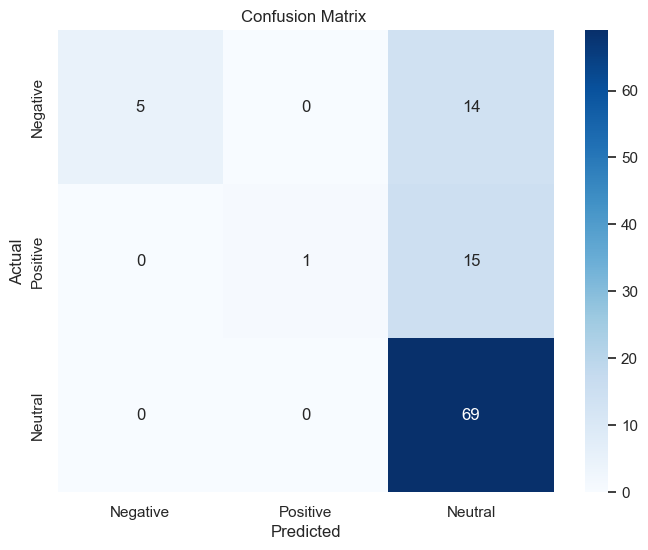

In [27]:
#   Evaluate the mode
accuracy_train = accuracy_score(y_train, model.predict(X_train_cv))
accuracy_val=accuracy_score(y_val,model.predict(X_val_cv))
accuracy_test = accuracy_score(y_test, y_pred)
print(f" Accuracy train: {accuracy_train:.4f}")
print(f" Accuracy val: {accuracy_val:.4f}")
print(f" Accuracy test: {accuracy_test:.4f}")

  # Generate classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

    # Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Negative', 'Positive', 'Neutral'],
                yticklabels=['Negative', 'Positive', 'Neutral'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix ')
plt.show()

In [ ]:
#Metrics

#Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

#Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

NameError: name 'Metrics' is not defined